In [1]:
using DataFrames
using Plots
using CategoricalArrays
using Random
using Imbalance
using MLJBase: machine, transform
using ScientificTypes
using TableTransforms
using CSV
using DataFrames

include("./utils.jl")

plot_data

### 1. Generate Random Data

In [2]:
rng = Random.default_rng()


num_rows = 100
num_cont_feats = 0
probs = [0.5, 0.2, 0.3]

extra_cat_feats = [3, 4, 2, 5]

X, y = generate_imbalanced_data(num_rows, num_cont_feats; probs, extra_cat_feats, type = "DF")

X = coerce(X, autotype(X, :few_to_finite))
X = coerce(X, OrderedFactor=>Multiclass)

Row,x1,x2,x3,x4
,Cat…,Cat…,Cat…,Cat…
1,1,3,2,4
2,1,4,1,5
3,3,1,2,1
4,3,3,1,2
5,1,1,2,3
6,3,1,1,3
7,2,4,1,3
8,2,1,2,4
9,3,1,2,2


In [3]:
# For TableTransforms
Xy = CSV.read("dataset.csv", DataFrame)
y_ind = 17
Xy = coerce(Xy, autotype(Xy, :string_to_multiclass))

types = schema(Xy).scitypes
cat_inds = findall( x -> x <: Multiclass, types)
Xy = Xy[:, cat_inds]

Row,Gender,H_Cal_Consump,Alcohol_Consump,Smoking,Food_Between_Meals,Fam_Hist,H_Cal_Burn,Transport,Body_Level
,Cat…,Cat…,Cat…,Cat…,Cat…,Cat…,Cat…,Cat…,Cat…
1,Female,yes,no,no,Frequently,yes,no,Public_Transportation,Body Level 1
2,Male,yes,Sometimes,no,Sometimes,yes,no,Public_Transportation,Body Level 1
3,Female,yes,Sometimes,no,Sometimes,no,no,Public_Transportation,Body Level 1
4,Female,yes,Sometimes,no,Sometimes,no,no,Public_Transportation,Body Level 1
5,Male,yes,no,no,Sometimes,yes,no,Automobile,Body Level 1
6,Male,yes,no,no,Sometimes,yes,no,Automobile,Body Level 1
7,Male,yes,Sometimes,no,Sometimes,yes,no,Public_Transportation,Body Level 1
8,Female,yes,no,no,Frequently,yes,no,Public_Transportation,Body Level 1
9,Female,no,no,no,Frequently,no,no,Public_Transportation,Body Level 1


### 2. Apply SMOTE

#### Using Imbalance Only

In [4]:
Xover, yover = smoten(X, y; k = 5, ratios = Dict(0=>1.2, 1=> 1.2, 2=>1.2), rng = 42)

(216×4 DataFrame
 Row │ x1    x2    x3    x4   
     │ Cat…  Cat…  Cat…  Cat… 
─────┼────────────────────────
   1 │ 1     3     2     4
   2 │ 1     4     1     5
   3 │ 3     1     2     1
   4 │ 3     3     1     2
   5 │ 1     1     2     3
   6 │ 3     1     1     3
   7 │ 2     4     1     3
   8 │ 2     1     2     4
  ⋮  │  ⋮     ⋮     ⋮     ⋮
 210 │ 1     2     2     4
 211 │ 1     3     1     5
 212 │ 3     4     2     5
 213 │ 1     2     2     4
 214 │ 3     4     2     5
 215 │ 2     2     2     4
 216 │ 1     3     1     3
              201 rows omitted, CategoricalValue{Int64, UInt32}[0, 2, 2, 2, 2, 0, 0, 2, 0, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

#### Using MLJ

In [5]:
smotenc_model = SMOTEN(k=5, ratios=Dict(0=>1.2, 1=> 1.2, 2=>1.2), rng=42)
mach = machine(smotenc_model)
Xover, yover = transform(mach, X, y)
Xover

Row,x1,x2,x3,x4
,Cat…,Cat…,Cat…,Cat…
1,1,3,2,4
2,1,4,1,5
3,3,1,2,1
4,3,3,1,2
5,1,1,2,3
6,3,1,1,3
7,2,4,1,3
8,2,1,2,4
9,3,1,2,2


#### Using TableTransforms

In [6]:
Xy

Row,Gender,H_Cal_Consump,Alcohol_Consump,Smoking,Food_Between_Meals,Fam_Hist,H_Cal_Burn,Transport,Body_Level
,Cat…,Cat…,Cat…,Cat…,Cat…,Cat…,Cat…,Cat…,Cat…
1,Female,yes,no,no,Frequently,yes,no,Public_Transportation,Body Level 1
2,Male,yes,Sometimes,no,Sometimes,yes,no,Public_Transportation,Body Level 1
3,Female,yes,Sometimes,no,Sometimes,no,no,Public_Transportation,Body Level 1
4,Female,yes,Sometimes,no,Sometimes,no,no,Public_Transportation,Body Level 1
5,Male,yes,no,no,Sometimes,yes,no,Automobile,Body Level 1
6,Male,yes,no,no,Sometimes,yes,no,Automobile,Body Level 1
7,Male,yes,Sometimes,no,Sometimes,yes,no,Public_Transportation,Body Level 1
8,Female,yes,no,no,Frequently,yes,no,Public_Transportation,Body Level 1
9,Female,no,no,no,Frequently,no,no,Public_Transportation,Body Level 1


In [7]:
y_ind = 2
smoten_model_t = SMOTEN_t(y_ind, ratios=Dict(1=> 1.2, 2=>1.2, 3=>1.2, 4=>1.2), rng=42)
Xyover = Xy |> smoten_model_t

Row,Gender,H_Cal_Consump,Alcohol_Consump,Smoking,Food_Between_Meals,Fam_Hist,H_Cal_Burn,Transport,Body_Level
,Cat…,Cat…,Cat…,Cat…,Cat…,Cat…,Cat…,Cat…,Cat…
1,Female,yes,no,no,Frequently,yes,no,Public_Transportation,Body Level 1
2,Male,yes,Sometimes,no,Sometimes,yes,no,Public_Transportation,Body Level 1
3,Female,yes,Sometimes,no,Sometimes,no,no,Public_Transportation,Body Level 1
4,Female,yes,Sometimes,no,Sometimes,no,no,Public_Transportation,Body Level 1
5,Male,yes,no,no,Sometimes,yes,no,Automobile,Body Level 1
6,Male,yes,no,no,Sometimes,yes,no,Automobile,Body Level 1
7,Male,yes,Sometimes,no,Sometimes,yes,no,Public_Transportation,Body Level 1
8,Female,yes,no,no,Frequently,yes,no,Public_Transportation,Body Level 1
9,Female,no,no,no,Frequently,no,no,Public_Transportation,Body Level 1


### 3. Plot the Results

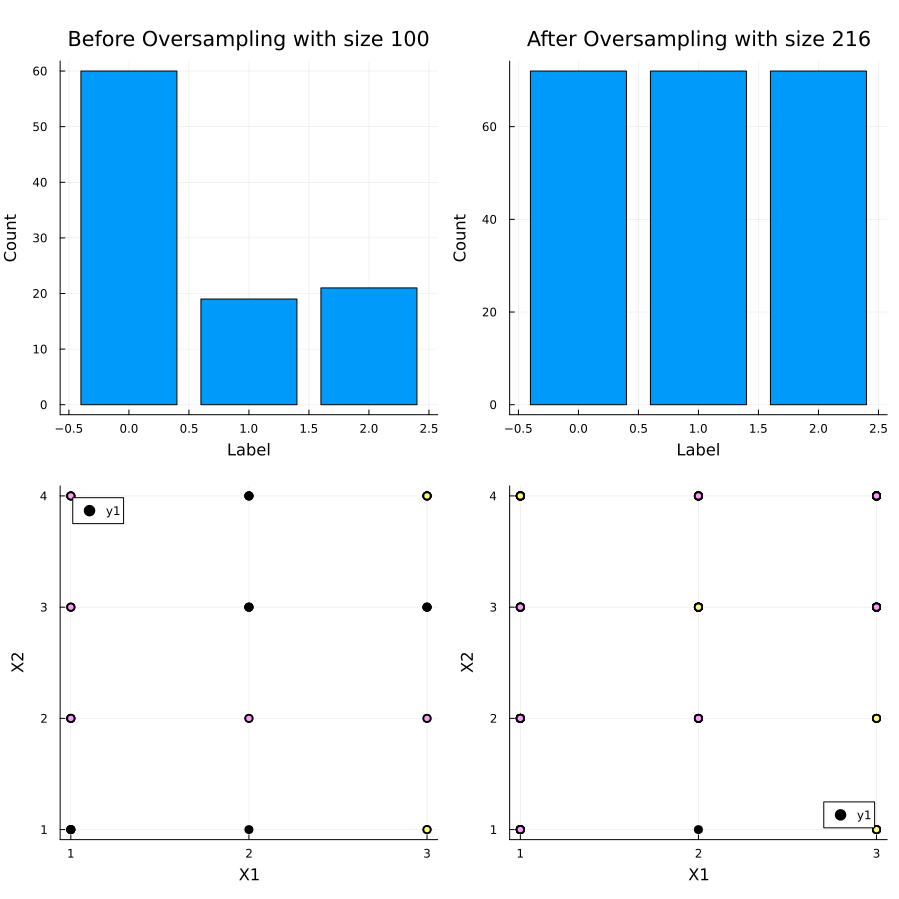

In [8]:
plot_data(y, yover, X, Xover)